# Normalization in the  Wavelet Transform

[Gill & Henriksen (1990)](http://adsabs.harvard.edu/abs/1990ApJ...365L..27G) describe a transform based on convolving a 2D map with Mexican Hat wavelet kernel of varying widths or "scales". From this, they take the average value of the positive response values from the convolution at each scale. This yields a 1D spectrum and Gill & Henriksen find a typical power-law slope of ~2.2-2.4 over a significant portion of the scales. The turn-over observed at large scales is likely due to edge effects of the FFT.

Upon implementing the transform as described in [TurbuStat](http://turbustat.readthedocs.org/en/latest/), we have found that the canonical power-law slope given by Gill & Henriksen is due to convolving the maps with an unnormalized wavelet kernel. When normalized, the distinctive power-law is lost and the spectrum is significantly flattened (~0.3-0.4) if we blindly fit a single power-law across all scales. Furthermore, there is no distinct turnover when one limits the scales tested. A good limit to the scales that can be properly tested when utilizing an FFT is half of the array size. This is the maximum scale recommended in the related Delta-Variance method (Ossenkopf et al. 2008;[Paper I](http://adsabs.harvard.edu/abs/2008A%26A...485..917O) and [Paper II](http://adsabs.harvard.edu/abs/2008A%26A...485..719O)).

The TurbuStat implementation is normalized by default, but the Gill & Henriksen results can be reproduced by specifying `scale_normalization=False`, as demonstrated below. The user receives warnings that the unnormalized results should not be used and are provided only as a demonstration.

In [7]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as p
%matplotlib inline
pylab.rcParams["figure.figsize"] = (10, 8)

In [8]:
from turbustat.statistics import Wavelet

In [18]:
from astropy.io import fits
# Load an example simulation
integ_intensity = fits.open("/mnt/MyRAID/Astrostat/SimSuite8/moments/homeerosSimSuite8Fiducial0_flatrho_0021_00_radmc_moment0.fits")[0]

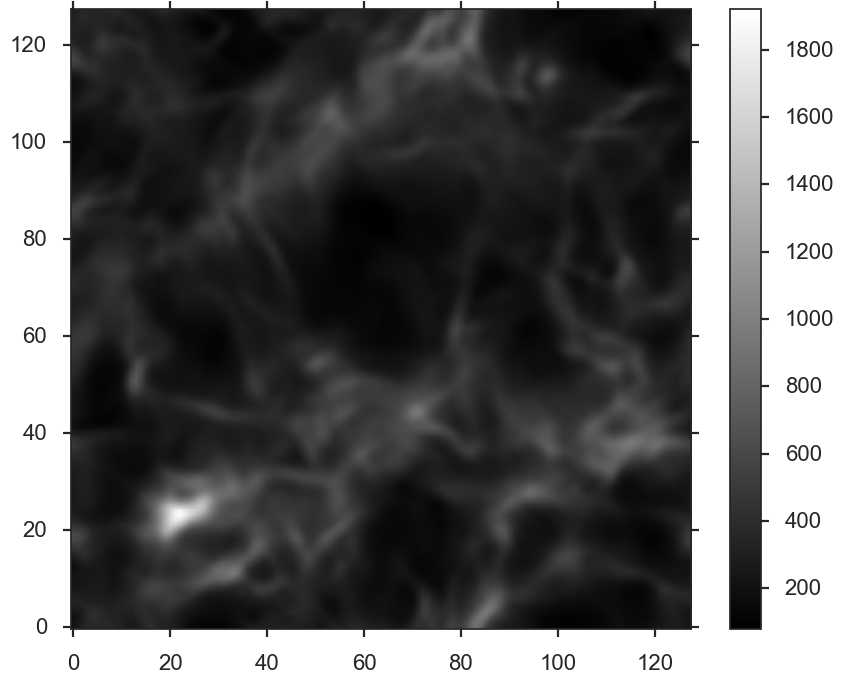

In [19]:
p.imshow(integ_intensity.data, origin='lower', cmap='gray')
p.colorbar()

First the unnormalize transform is shown:

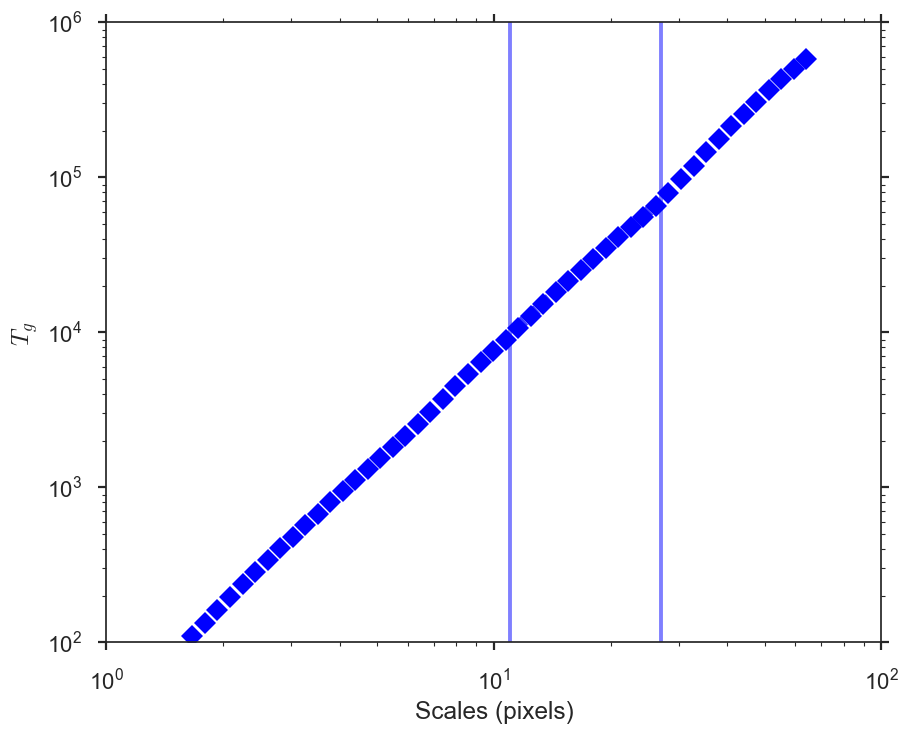

Slope: 2.20+/-0.02


In [20]:
unnorm_wave = Wavelet(integ_intensity, scale_normalization=False)
unnorm_wave.run(verbose=True, xlow=11., xhigh=27.)
print(r"Slope: %0.2f+/-%0.2f" % (unnorm_wave.slope, unnorm_wave.slope_err))

Now the normalized version:

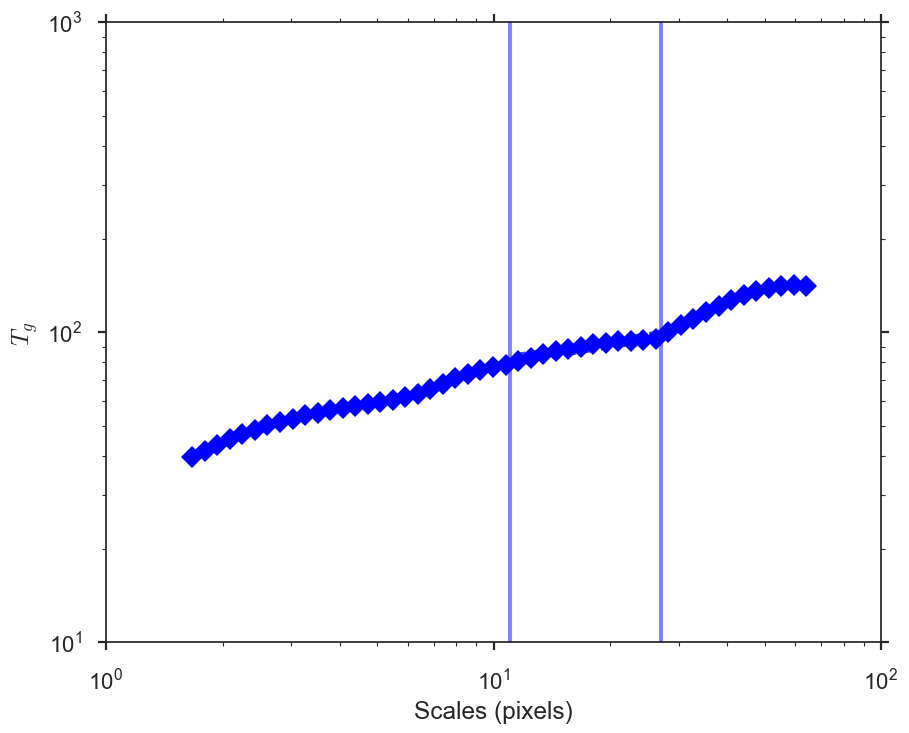

Slope: 0.20+/-0.02


In [21]:
norm_wave = Wavelet(integ_intensity, scale_normalization=True)
norm_wave.run(verbose=True, xlow=11., xhigh=27.)
print(r"Slope: %0.2f+/-%0.2f" % (norm_wave.slope, norm_wave.slope_err))

Tthe slope is dramatically shallower and the minor deviations have become more amplified.

The Mexican Hat wavelet (or the Marr wavelet) has a normalization factor of: $$\frac{1}{\pi \sigma^4}$$
TurbuStat utilizes the [astropy implementation](http://docs.astropy.org/en/stable/api/astropy.convolution.MexicanHat2DKernel.html), which includes the proper normalization factor.
To make this scale-invariant, we can think of the Mexican Hat as the second derivative of a Gaussian (up to a sign), or the Laplacian of a Gaussian.

A 2D Gaussian kernel has a normalization of: $$\frac{1}{2\pi \sigma^2},$$ thus it carries units of length$^{-2}$. Each spatial derivative introduces another length$^{-1}$ unit; this leads to the $\sigma^{-4}$ factor in the Mexican Hat normalization. To make this scale-invariant, we want to return the transform to units of length$^{-2}$ and so the convolution at each scale should be multiplied by $\sigma^2$. A rigorous demonstration of space-scale transform is presented by [Lindeburg (1998)](http://link.springer.com/article/10.1023/A:1008045108935#page-1).

The form of the kernel shown by Gill & Henriksen is both unnormalized and appears to be defined for the 1-dimensional case. It is somewhat unclear what the exact form of the kernel used the authors used, however our results indicate that it was likely unnormalized and thus severely effects the results and conclusions in the paper.

It is vital to recognize that the Wavelet transform defined almost identically to Delta-Variance. However, Delta-Variance uses the variance within the convolved maps at each scale to define the one-dimensional spectrum. In the normalized formulation, this is a more sensible metric to use and there are several papers on its use, including corrections for pitfalls such as boundary effects. Using the variance instead of the mean also allows for a direct comparison between curves at the same scale since the variance is invariant to shifts in a distribution.

Here we show an alternate simulation with different physical properties. This demonstrates that the slope and the power-law scales are marginally changed from those shown above and are dominated by the kernel normalization:

In [22]:
integ_intensity_2 = fits.open("/mnt/MyRAID/Astrostat/SimSuite8/moments/homeerosSimSuite8Design0_flatrho_0021_00_radmc_moment0.fits")[0]

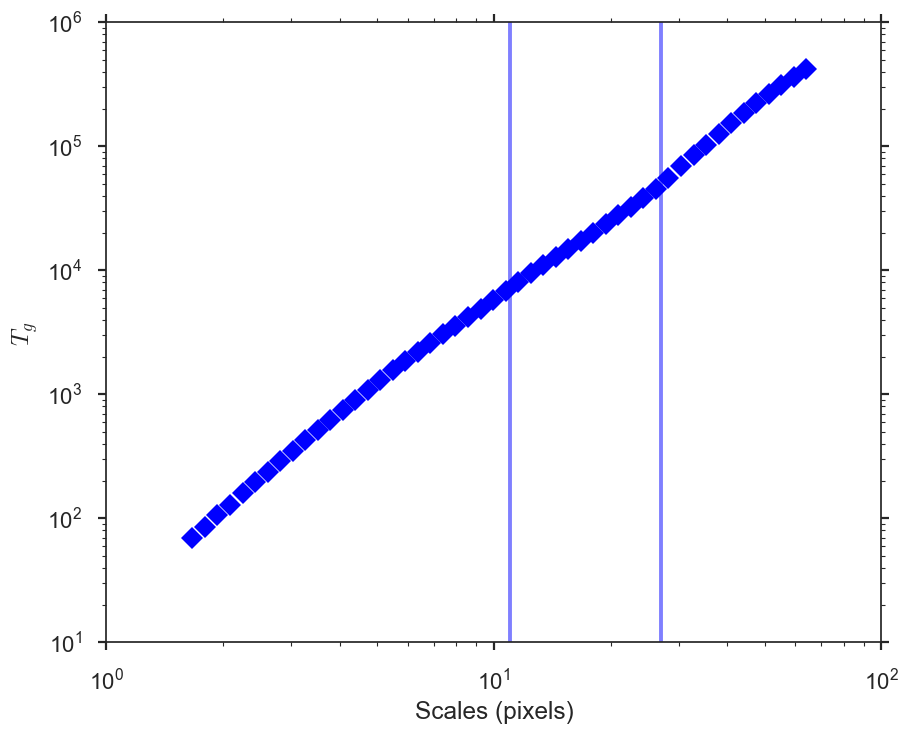

Slope: 2.09+/-0.02


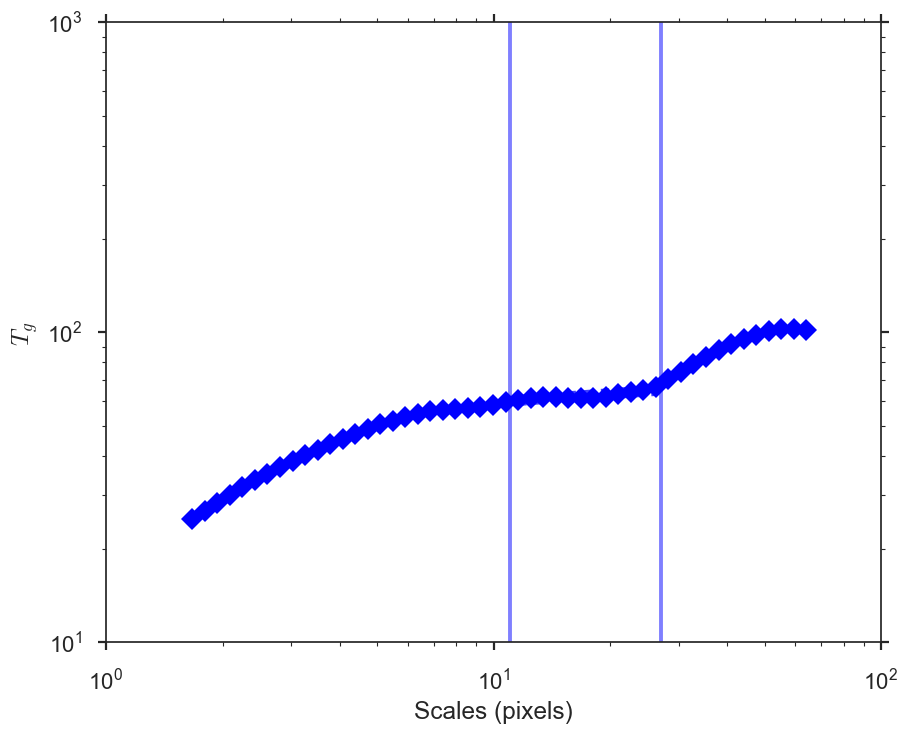

Slope: 0.09+/-0.02


In [25]:
unnorm_wave = Wavelet(integ_intensity_2, scale_normalization=False)
unnorm_wave.run(verbose=True, xlow=11., xhigh=27.)
print(r"Slope: %0.2f+/-%0.2f" % (unnorm_wave.slope, unnorm_wave.slope_err))
norm_wave = Wavelet(integ_intensity_2, hdr_2, scale_normalization=True)
norm_wave.run(verbose=True, xlow=11., xhigh=27.)
print(r"Slope: %0.2f+/-%0.2f" % (norm_wave.slope, norm_wave.slope_err))

What do the normalized versions look like together?

/home/eric/.local/lib/python2.7/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     160.3
Date:                Fri, 17 Mar 2017   Prob (F-statistic):           1.76e-07
Time:                        14:59:17   Log-Likelihood:                 45.363
No. Observations:                  12   AIC:                            -86.73
Df Residuals:                      10   BIC:                            -85.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.7060      0.019     87.574      0.0

/home/eric/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


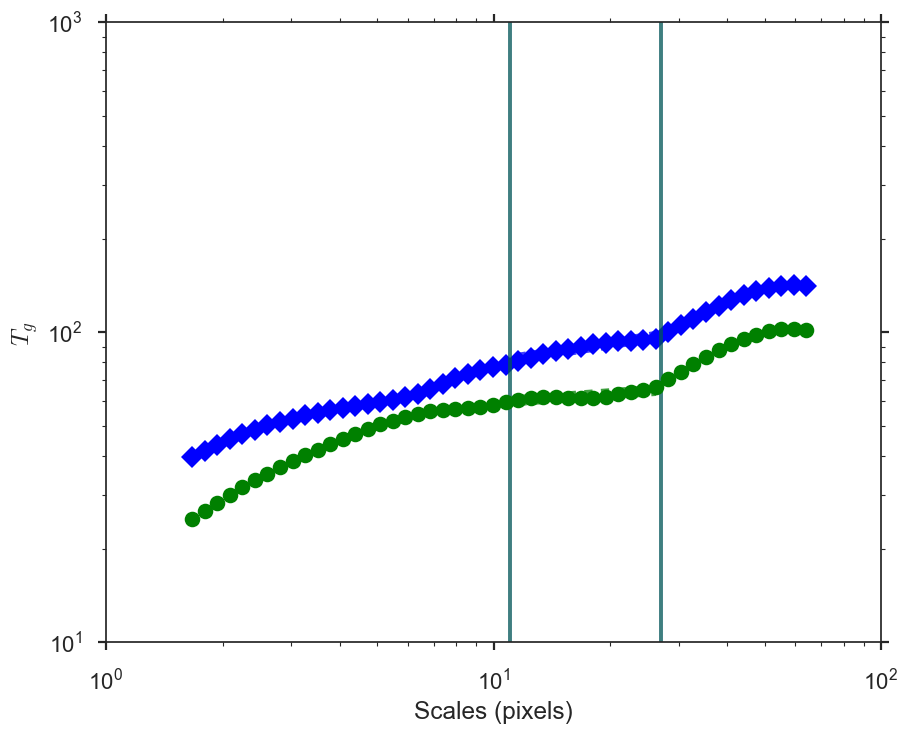

In [26]:
from turbustat.statistics import Wavelet_Distance
norm_wave = Wavelet_Distance(integ_intensity, integ_intensity_2, xlow=11., xhigh=27.)
norm_wave.distance_metric(verbose=True)

The slopes are ~0.06 apart, which is a statistically significant difference given their standard errors.

The Delta-Variance demonstrates that there are differences between the transforms that the mean of the response is insensitive to:

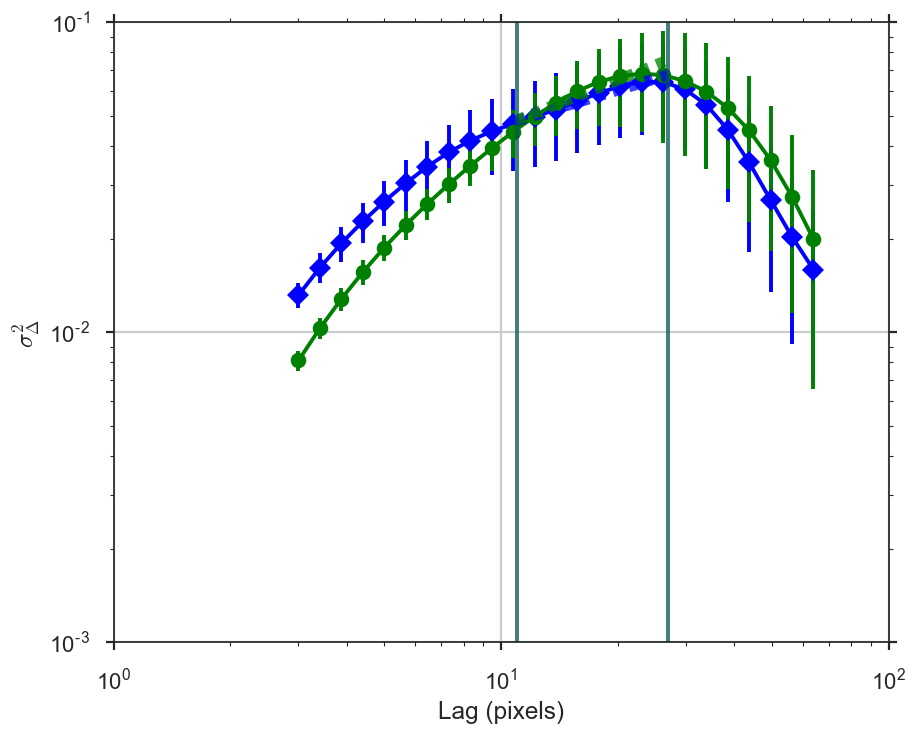

Delta-Variance slopes: 0.37782532525+/-0.0338269853258, 0.496568398527+/-0.0676328929371


In [29]:
from turbustat.statistics import DeltaVariance_Distance

delvar = DeltaVariance_Distance(integ_intensity, integ_intensity_2, xlow=11., xhigh=27.)
delvar.distance_metric(verbose=True)
print("Delta-Variance slopes: {0}+/-{1}, {2}+/-{3}".format(delvar.delvar1.slope, delvar.delvar1.slope_err,
                                                           delvar.delvar2.slope, delvar.delvar2.slope_err))

Since the methods are identical apart from the final metric that they use for each scale, we conclude that Delta-Variance is the superior tool to use. Our results indicate that the differences in the Delta-Variance curves are an effective distance metric that reliably tracks changes in the underlying physics. The results obtained with the Gill & Henriksen technique are unclear in their response to physical changes, given the parameter space we have tested.